In [ ]:
!pip install PyWavelets


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 43.8 MB/s eta 0:00:00


Enter the scale factor (e.g., 2.0 for 2x upscaling): 2


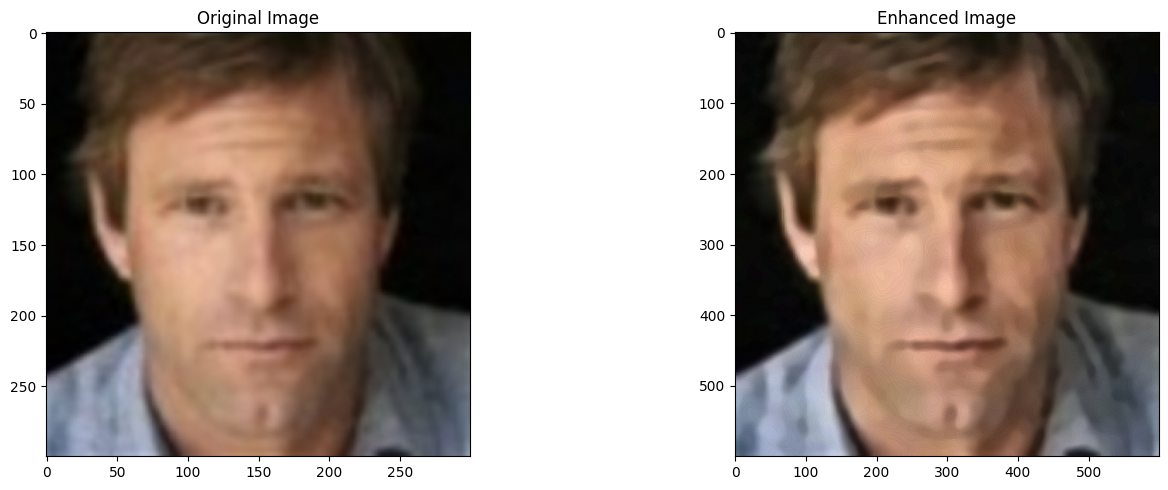

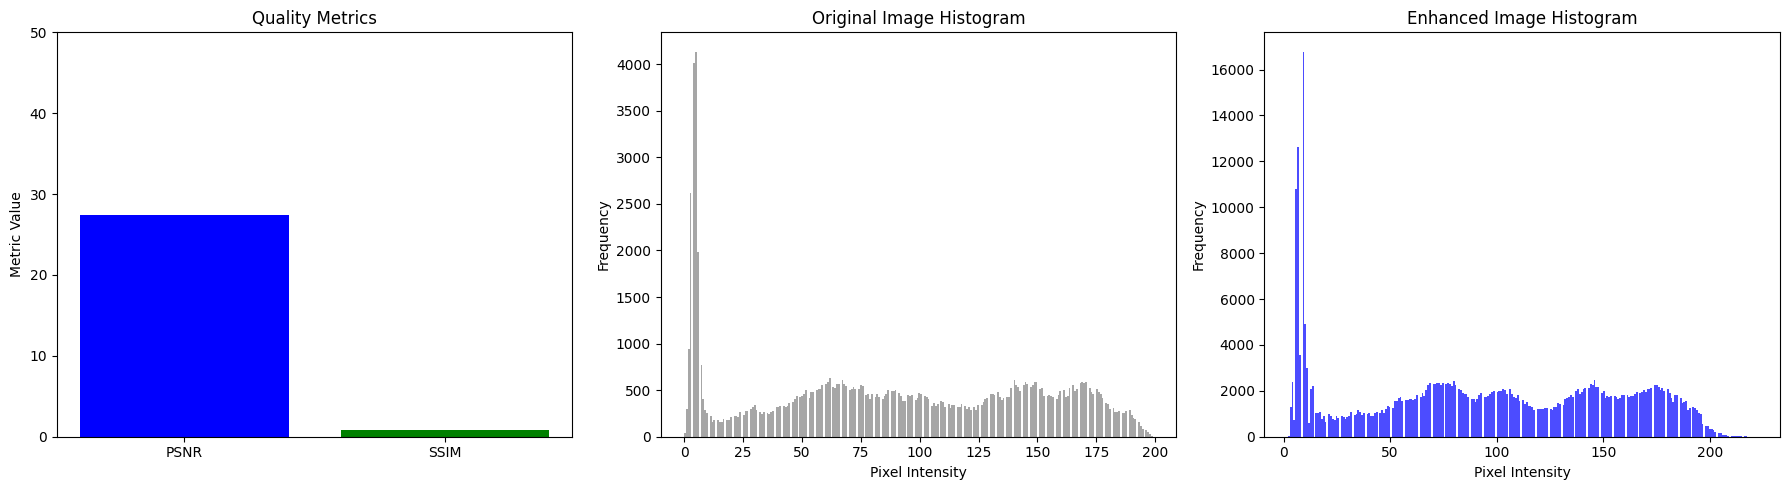

In [ ]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from pathlib import Path
from typing import Tuple, Union, Optional
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

class ImageSuperResolution:

    def __init__(self,
                 target_size: Optional[Tuple[int, int]] = None,
                 scale_factor: Optional[float] = None,
                 wavelet_level: int = 2,
                 ibp_iterations: int = 10,
                 wavelet_boost: float = 1.5):
        self.target_size = target_size
        self.scale_factor = scale_factor or 2.0
        self.wavelet_level = wavelet_level
        self.ibp_iterations = ibp_iterations
        self.wavelet_boost = wavelet_boost

    def _validate_image(self, image: np.ndarray) -> np.ndarray:
        """Validate and normalize input image."""
        if image is None:
            raise ValueError("Input image is None")

        if not isinstance(image, np.ndarray):
            raise TypeError("Input must be a numpy array")

        image = image.astype(np.float32)

        if image.max() > 1.0:
            image /= 255.0

        return image

    def _calculate_scale_factors(self, image_shape: Tuple[int, ...]) -> Tuple[float, float]:
        """
        Calculate the scale factors for resizing based on target size or predefined scale factor.

        Parameters:
            image_shape (Tuple[int, ...]): The shape of the input image (height, width, channels).

        Returns:
            Tuple[float, float]: Scale factors for height and width.
        """
        if self.target_size:
            return (self.target_size[1] / image_shape[0],
                   self.target_size[0] / image_shape[1])
        return (self.scale_factor, self.scale_factor)

    def downsample_image(self,
                        image: np.ndarray,
                        target_size: Optional[Tuple[int, int]] = None) -> np.ndarray:
        """
        Downsamples the image to a lower resolution with anti-aliasing using Gaussian blur.

        Parameters:
            image (np.ndarray): Input high-resolution image.
            target_size (Optional[Tuple[int, int]]): Target size for downsampling (width, height).

        Returns:
            np.ndarray: Downsampled image.
        """
        if target_size:
            new_w, new_h = target_size
        else:
            h, w = image.shape[:2]
            scale_h, scale_w = self._calculate_scale_factors(image.shape)
            new_h, new_w = int(h / scale_h), int(w / scale_w)

        # Apply Gaussian blur before downsampling to prevent aliasing
        sigma = 0.5 * max(image.shape[0] / new_h, image.shape[1] / new_w)
        kernel_size = int(2 * round(2 * sigma) + 1)
        image = cv2.GaussianBlur(image, (kernel_size, kernel_size), sigma)

        return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

    def upsample_image(self,
                      image: np.ndarray,
                      target_size: Optional[Tuple[int, int]] = None) -> np.ndarray:
        """
        Upsamples the image to a higher resolution using bicubic interpolation.

        Parameters:
            image (np.ndarray): Input low-resolution image.
            target_size (Optional[Tuple[int, int]]): Target size for upsampling (width, height).

        Returns:
            np.ndarray: Upsampled image.
        """
        if target_size:
            new_w, new_h = target_size
        else:
            h, w = image.shape[:2]
            scale_h, scale_w = self._calculate_scale_factors(image.shape)
            new_h, new_w = int(h * scale_h), int(w * scale_w)

        return cv2.resize(image, (new_w, new_h), interpolation=cv2.INTER_CUBIC)

    def iterative_back_projection(self,
                                lr_image: np.ndarray,
                                hr_estimate: np.ndarray) -> np.ndarray:
        """
        Refines the high-resolution estimate using Iterative Back Projection (IBP).

        Parameters:
            lr_image (np.ndarray): The original low-resolution image.
            hr_estimate (np.ndarray): The initially upscaled high-resolution image.

        Returns:
            np.ndarray: Refined high-resolution image.
        """
        hr_est = hr_estimate.copy()
        target_size = hr_est.shape[:2][::-1]  # (width, height)
        lr_size = lr_image.shape[:2][::-1]

        for i in range(self.ibp_iterations):
            downsampled = self.downsample_image(hr_est, lr_size)
            diff = lr_image - downsampled
            upscaled_diff = self.upsample_image(diff, target_size)
            hr_est += upscaled_diff * 0.1

            if (i + 1) % 2 == 0:
                logger.debug(f"IBP Iteration {i+1}/{self.ibp_iterations}")

        return hr_est

    def frequency_domain_enhancement(self, image: np.ndarray) -> np.ndarray:
        """
        Enhances image details using frequency domain processing (Wavelet Transform).

        Parameters:
            image (np.ndarray): Input image to be enhanced.

        Returns:
            np.ndarray: Enhanced image after wavelet transform processing.
        """
        if image.ndim == 3:
            enhanced = np.zeros_like(image)
            for channel in range(image.shape[2]):
                coeffs = pywt.wavedec2(image[..., channel], 'haar',
                                     level=self.wavelet_level)
                coeffs = list(coeffs)

                for level in range(1, len(coeffs)):
                    coeffs[level] = tuple(band * self.wavelet_boost
                                        for band in coeffs[level])

                enhanced[..., channel] = pywt.waverec2(coeffs, 'haar')
            return enhanced
        else:
            coeffs = pywt.wavedec2(image, 'haar', level=self.wavelet_level)
            coeffs = list(coeffs)
            coeffs[1:] = [(cH * self.wavelet_boost, cV * self.wavelet_boost,
                          cD * self.wavelet_boost) for cH, cV, cD in coeffs[1:]]
            return pywt.waverec2(coeffs, 'haar')

    def apply_edge_preserving_filter(self, image: np.ndarray) -> np.ndarray:
        """
        Applies edge-preserving filtering using bilateral filtering.

        Parameters:
            image (np.ndarray): Input image.

        Returns:
            np.ndarray: Image with enhanced edges.
        """
        image = np.clip(image * 255, 0, 255).astype(np.uint8)

        if image.ndim == 2:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        elif image.shape[2] > 3:
            image = image[:, :, :3]

        filtered = cv2.bilateralFilter(image, 9, 75, 75)
        return filtered.astype(np.float32) / 255.0

    def remove_noise(self, image: np.ndarray, h: int = 5, hForColor: int = 10) -> np.ndarray:
      """Removes noise from an image using Non-Local Means Denoising."""

      # Ensure image is in uint8 format
      if image.dtype != np.uint8:
          image = np.clip(image * 255, 0, 255).astype(np.uint8)

      # Ensure image has 3 or 4 channels
      if len(image.shape) == 2:  # Grayscale image, convert to 3-channel
          image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

      elif image.shape[2] == 1:  # Single-channel grayscale, convert to 3-channel
          image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

      image= cv2.fastNlMeansDenoisingColored(image, None, h, hForColor, 7, 21)

      # Create the sharpening kernel
      kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])

      # Sharpen the image
      sharpened_image = cv2.filter2D(image, -1, kernel)

      return sharpened_image


    def apply_clahe(self,image: np.ndarray, clip_limit: float = 1.0, tile_grid_size: tuple = (16, 16)) -> np.ndarray:
      """
      Enhances an image using CLAHE (Contrast Limited Adaptive Histogram Equalization).

      Parameters:
          image (np.ndarray): Input image (uint8, RGB)
          clip_limit (float): Threshold for contrast clipping (default: 2.0)
          tile_grid_size (tuple): Size of grid for histogram equalization (default: (8,8))

      Returns:
          np.ndarray: Enhanced color image
      """
      # Convert image to LAB color space
      lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
      l, a, b = cv2.split(lab)  # Extract L (lightness), A, B channels

      # Apply CLAHE to the L (lightness) channel only
      clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
      l_clahe = clahe.apply(l)

      # Merge the modified L channel back with A and B
      lab_clahe = cv2.merge((l_clahe, a, b))

      # Convert back to RGB color space
      enhanced = cv2.cvtColor(lab_clahe, cv2.COLOR_LAB2RGB)

      return enhanced





    def enhance(self, image_path: Union[str, Path]) -> Tuple[np.ndarray, dict]:
        """
        Main enhancement function with pipeline

        Parameters:
            image_path (Union[str, Path]): Path to the input image.

        Returns:
            Tuple[np.ndarray, dict]: Enhanced image and quality metrics.
        """

        image = cv2.imread(str(image_path))
        if image is None:
            raise FileNotFoundError(f"Could not load image: {image_path}")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self._validate_image(image)

        # Calculate initial sizes
        if self.target_size:
            lr_size = (self.target_size[0] // 2, self.target_size[1] // 2)
        else:
            h, w = image.shape[:2]
            scale_h, scale_w = self._calculate_scale_factors(image.shape)
            lr_size = (int(w / scale_w), int(h / scale_h))

        # Create low-resolution version
        lr_image = self.downsample_image(image, lr_size)

        # Initial upscaling
        hr_estimate = self.upsample_image(lr_image, self.target_size)

        # ------------------- Pipeline --------------------------------- #
        hr_refined = self.iterative_back_projection(lr_image, hr_estimate)

        hr_enhanced = self.frequency_domain_enhancement(hr_refined)

        hr_output = self.apply_edge_preserving_filter(hr_enhanced)

        denoice_img = self.remove_noise(hr_output)

        final_output = self.apply_clahe(denoice_img)

        metrics = self.evaluate_quality(image, final_output)

        return final_output, metrics


    @staticmethod
    def evaluate_quality(original: np.ndarray, processed: np.ndarray) -> dict:
        if original.max() <= 1.0:
            original = (original * 255).astype(np.uint8)
        if processed.max() <= 1.0:
            processed = (processed * 255).astype(np.uint8)

        # Resize original to match processed if sizes differ
        if original.shape != processed.shape:
            original = cv2.resize(original, (processed.shape[1], processed.shape[0]))

        psnr_val = psnr(original, processed)
        ssim_val = ssim(original, processed, channel_axis=2 if original.ndim == 3 else None)

        return {
            'psnr': psnr_val,
            'ssim': ssim_val
        }

    @staticmethod
    def plot_metrics_and_histograms(original: np.ndarray, enhanced: np.ndarray, metrics: dict):
      """Plots PSNR & SSIM along with histograms of the original and enhanced images."""
      fig, axes = plt.subplots(1, 3, figsize=(18, 5))

      # Bar plot for PSNR & SSIM
      axes[0].bar(["PSNR", "SSIM"], [metrics["psnr"], metrics["ssim"]], color=['blue', 'green'])
      axes[0].set_ylim(0, max(50, metrics["psnr"] + 5))  # Dynamic range
      axes[0].set_ylabel("Metric Value")
      axes[0].set_title("Quality Metrics")

      # Histogram for original image
      original_gray = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)
      axes[1].hist(original_gray.ravel(), bins=256, color='gray', alpha=0.7)
      axes[1].set_title("Original Image Histogram")
      axes[1].set_xlabel("Pixel Intensity")
      axes[1].set_ylabel("Frequency")

      # Histogram for enhanced image
      enhanced_gray = cv2.cvtColor((enhanced ), cv2.COLOR_RGB2GRAY)
      axes[2].hist(enhanced_gray.ravel(), bins=256, color='blue', alpha=0.7)
      axes[2].set_title("Enhanced Image Histogram")
      axes[2].set_xlabel("Pixel Intensity")
      axes[2].set_ylabel("Frequency")

      plt.tight_layout()
      plt.show()


def bicubic_upsample(image: np.ndarray, target_size: Tuple[int, int]) -> np.ndarray:
    return cv2.resize(image, target_size, interpolation=cv2.INTER_CUBIC)

# Example usage
if __name__ == "__main__":
    try:
        # Get user input for scale factor
        scale_factor = float(input("Enter the scale factor (e.g., 2.0 for 2x upscaling): ").strip())

        # Load the image to determine the original size
        image_path = "/content/low_res_image2.jpg"
        original = cv2.imread(image_path)
        if original is None:
            raise FileNotFoundError(f"Could not load image: {image_path}")

        original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        orig_h, orig_w = original.shape[:2]

        # Calculate target size based on scale factor
        target_size = (int(orig_w * scale_factor), int(orig_h * scale_factor))

        # Initialize super-resolution processor with dynamic target size
        sr_processor = ImageSuperResolution(
            target_size=target_size,
            wavelet_level=2,
            ibp_iterations=5,
            wavelet_boost=1.5
        )

        # Perform enhancement
        enhanced_image, quality_metrics = sr_processor.enhance(image_path)

        # Visualize results
        plt.figure(figsize=(15, 5))

        plt.subplot(121)
        plt.imshow(original / 255.0)
        plt.title("Original Image")

        plt.subplot(122)
        plt.imshow(enhanced_image)
        plt.title("Enhanced Image")

        plt.tight_layout()
        plt.show()

        # Plot quality metrics and histograms
        sr_processor.plot_metrics_and_histograms(original=original, enhanced=enhanced_image, metrics=quality_metrics)

        logger.info(f"Enhancement complete. Metrics: {quality_metrics}")

    except Exception as e:
        logger.error(f"Error during image enhancement: {str(e)}")


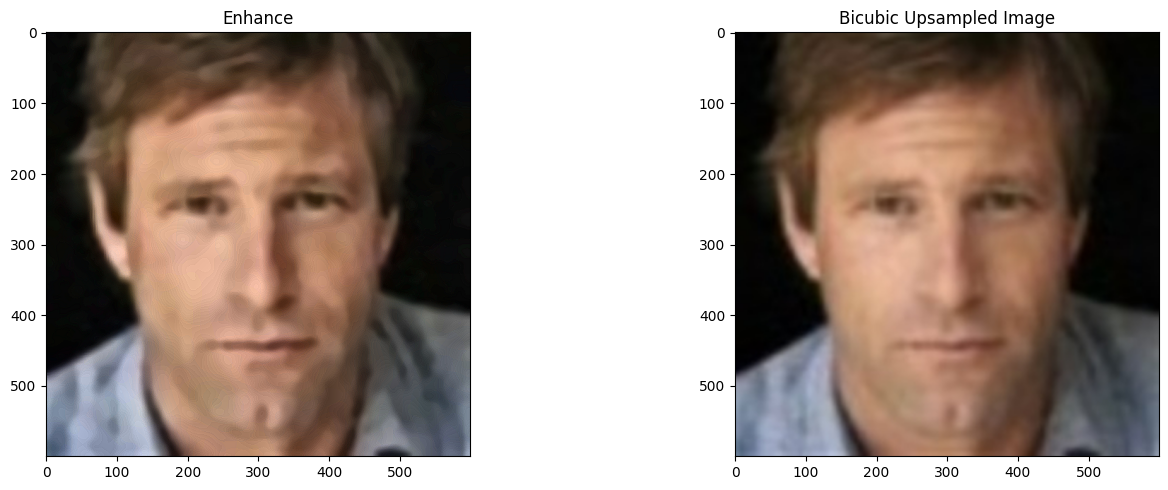

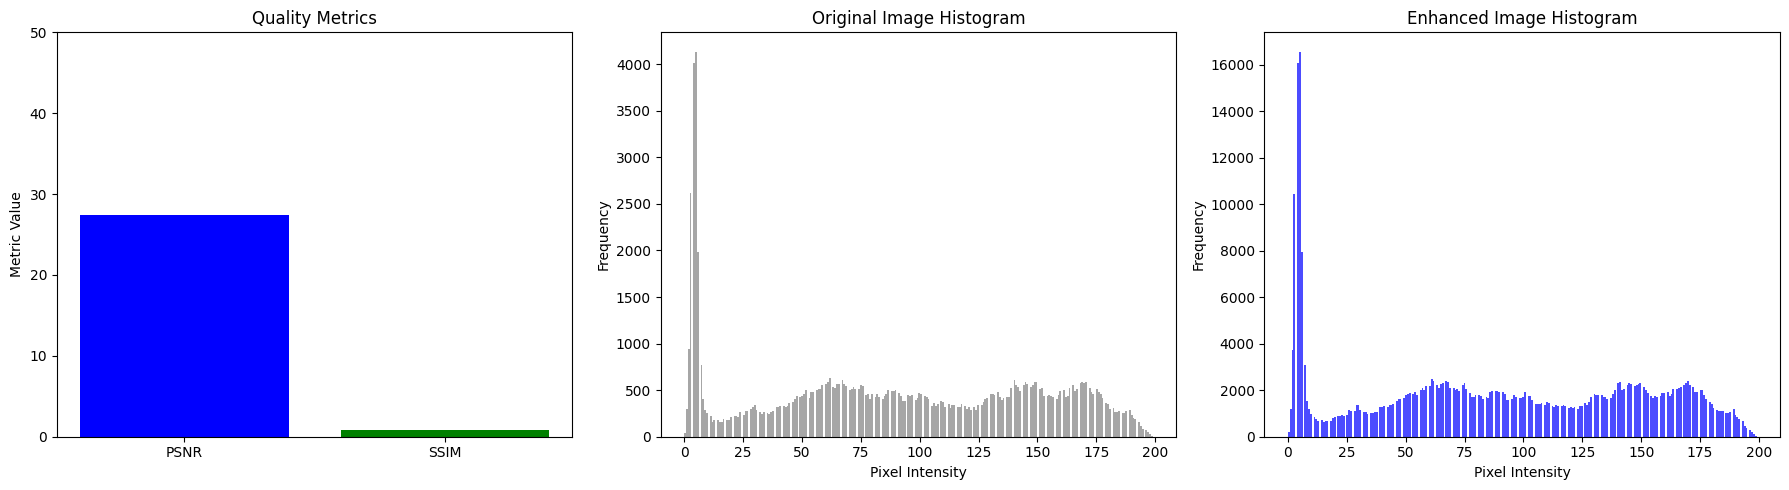

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.imshow(enhanced_image)
plt.title("Enhance")
bicubic = bicubic_upsample(original, (enhanced_image.shape[1], enhanced_image.shape[0]))
diff_bicubic = np.abs(bicubic - enhanced_image)
plt.subplot(122)
plt.imshow(bicubic)
plt.title("Bicubic Upsampled Image")

plt.tight_layout()
plt.show()

metrics = sr_processor.evaluate_quality(original, bicubic)
sr_processor.plot_metrics_and_histograms(original=original, enhanced=bicubic, metrics=quality_metrics)
